In [1]:
!pip install Tensorflow
!pip install Keras
!pip install scikit-learn
!pip install imblearn
!pip install scikeras
!pip install gensim
!pip install keras-tuner


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.pipeline import Pipeline
from collections import Counter

import tensorflow
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D, MaxPooling1D, TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution1D as Conv1D, InputLayer, concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.utils import set_random_seed
from tensorflow.data import Dataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from gensim.models import Word2Vec
import os
import zipfile
import keras_tuner as kt

In [3]:
set_random_seed(8)

## Importing the data

In [4]:
df = pd.read_csv('data/original_v2_data.csv', index_col =0)
df

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1
...,...,...
28614,jews to celebrate rosh hashasha or something,1
28615,internal affairs investigator disappointed con...,1
28616,the most beautiful acceptance speech this week...,0
28617,mars probe destroyed by orbiting spielberg-gat...,1


In [5]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [6]:
df.dropna(inplace = True)

In [7]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [8]:
df.shape

(28619, 2)

## Splitting data

In [9]:
X = df["headline"]
y = df["is_sarcastic"]

splitting data 70\% train, 10\% validation, 20\% test

In [10]:
#splitting the data into train, validation, test
X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2, random_state = 8)

#splitting the (training) data into training and validating data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.125, random_state = 8)

In [11]:
X_train.sample(5)

4049                  being moody helps us adapt to change
5126                              bandai recalls lady gaga
870      john legend tries in earnest to talk kanye wes...
18122    want to sleep in 'the world's largest grave'? ...
19098    ayesha curry lands cooking show on the food ne...
Name: headline, dtype: object

In [12]:
y_train.sample(5)

20986    1
24440    1
8150     1
8251     1
15112    1
Name: is_sarcastic, dtype: int64

## Model statistics

In [13]:
def plotCurves(history, model_name):
    results = pd.DataFrame(history.history)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    ax1.plot(results.index, results.loss)
    ax1.plot(results.index, results.val_loss)
    ax1.set_title(model_name)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Binary Crossentropy Loss")
    ax1.legend(["Training Loss", "Validation Loss"])
   


 
    ax2.plot(results.index, results.accuracy)
    ax2.plot(results.index, results.val_accuracy)
    ax2.set_title(model_name)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["Training Accuracy", "Validation Accuracy"])
 

    fig.show()

In [14]:


def printModelStats(model, X, y):

    y_pred = model.predict(X)
    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred > 0.5] = 1    


    print(classification_report(y, y_pred, target_names = ['Sarcastic', 'Not Sarcastic']))
   
    cm = confusion_matrix(y, y_pred)
    print("The confusion matrix:")
    print(cm)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    sns.heatmap((cm_percent), annot = True, cmap = "Blues").set(title ="Confusion Matrix Expressed in %")

## Tokenizing

In [15]:
tokenizer = Tokenizer(oov_token="<OOV>")

#fitting tokenizer on training set
tokenizer.fit_on_texts(X_train)

#choosing max length to be 20, which is is more than 2*STD +- mean number of words per headline
max_length = 20 # max([len(sentence.split()) for sentence in X_train])

X_train_untk = X_train

In [16]:
#tokenizing headlines
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_length, padding = "post")
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = max_length, padding = "post")
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_length, padding = "post")

In [17]:
vocab_size = len(tokenizer.word_index)+1
print(f'The size of vocabulary: {vocab_size}')

The size of vocabulary: 25928


## Simple directional GRU

With own embedding

In [18]:
output_dimension = 100

def buildModel1(hp):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length))
    model.add((GRU(hp.Choice('units1', [32,64,128]))))
    model.add(Dropout(hp.Choice('rate1', [0.3,0.5, 0.7])))
    model.add(Dense(hp.Choice('units2', [8, 16, 32]), activation = "relu"))
    model.add(Dropout(hp.Choice('rate2', [0.3,0.5, 0.7])))
    model.add(Dense(1, activation = "sigmoid"))
    model.summary()
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [19]:

# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)


In [21]:
# history = model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)


tuner = kt.RandomSearch(buildModel1, objective= 'val_loss', seed = 8, max_trials=10, directory= 'C:/projects', project_name = 'model_GRU_original_1')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])


Reloading Tuner from C:/projects\model_GRU_original_1\tuner0.json


In [22]:
best_model = tuner.get_best_models()[0]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           2592800   
                                                                 
 gru (GRU)                   (None, 64)                31872     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2626785 (10.02 MB)
Trainable params: 2626

In [23]:
best_hp = tuner.get_best_hyperparameters()[0]
best_model_1 = tuner.hypermodel.build(best_hp)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           2592800   
                                                                 
 gru_1 (GRU)                 (None, 64)                31872     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2626785 (10.02 MB)
Trainable params: 262

In [24]:
history = best_model_1.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)


Epoch 1/20


627/627 [==============================] - 24s 32ms/step - loss: 0.4917 - accuracy: 0.7344 - val_loss: 0.3197 - val_accuracy: 0.8592
Epoch 2/20
627/627 [==============================] - 19s 31ms/step - loss: 0.2222 - accuracy: 0.9201 - val_loss: 0.3519 - val_accuracy: 0.8665
Epoch 3/20
627/627 [==============================] - 20s 32ms/step - loss: 0.0999 - accuracy: 0.9663 - val_loss: 0.3919 - val_accuracy: 0.8519
Epoch 3: early stopping


C:\Users\Bodine Stubbé\AppData\Local\Temp\ipykernel_20136\2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


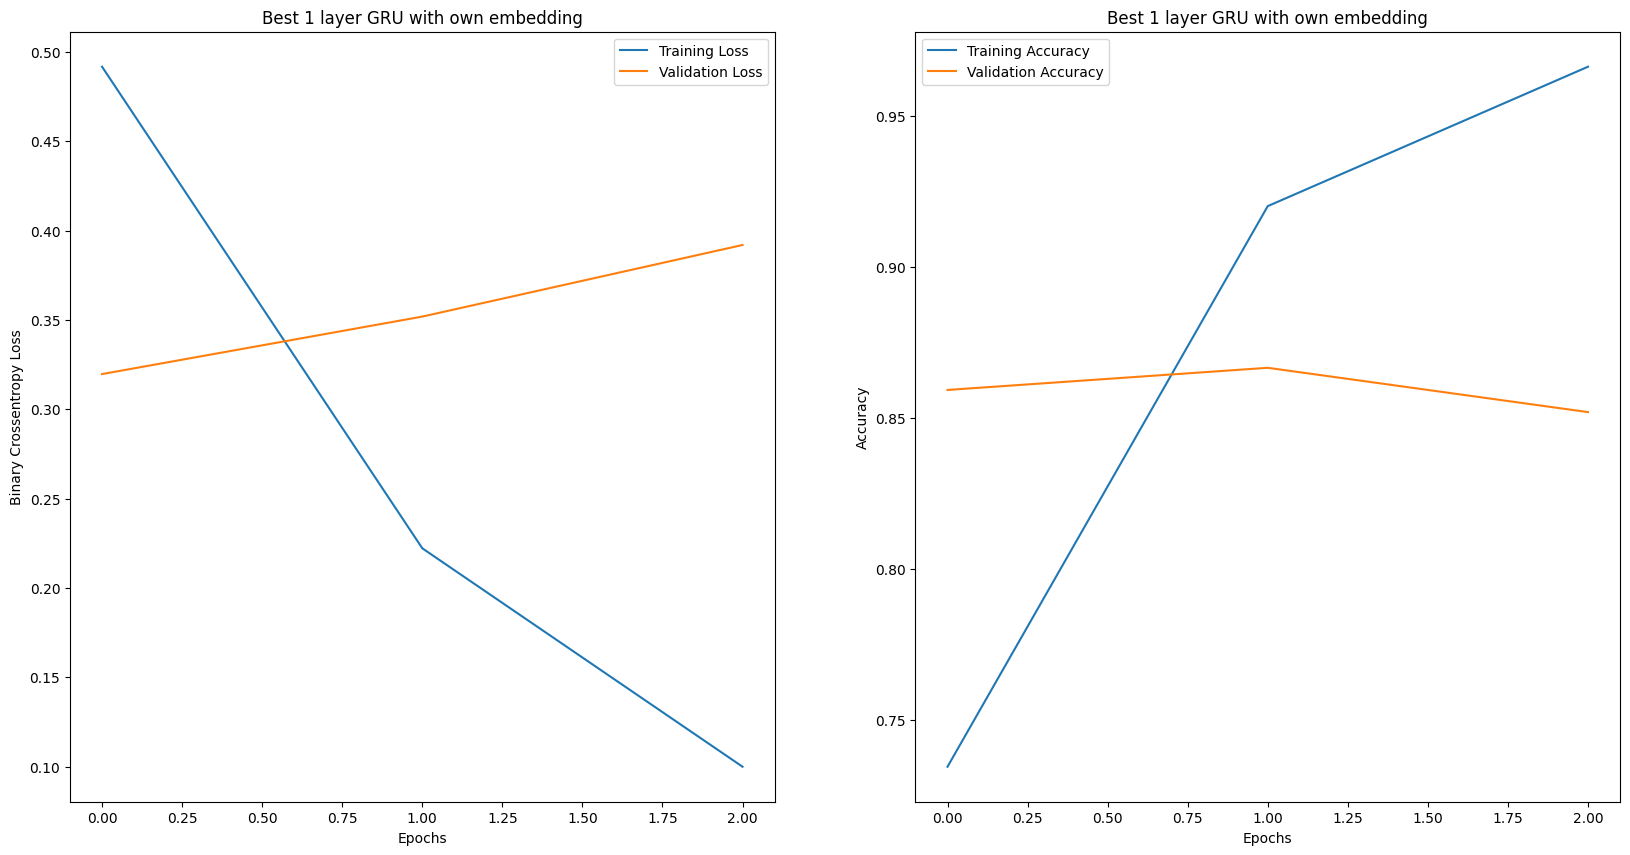

In [25]:
plotCurves(history, "Best 1 layer GRU with own embedding")

printModelStats(model)

179/179 [==============================] - 1s 4ms/step
               precision    recall  f1-score   support

    Sarcastic       0.88      0.81      0.85      2979
Not Sarcastic       0.81      0.88      0.85      2745

     accuracy                           0.85      5724
    macro avg       0.85      0.85      0.85      5724
 weighted avg       0.85      0.85      0.85      5724

The confusion matrix:
[[2425  554]
 [ 320 2425]]


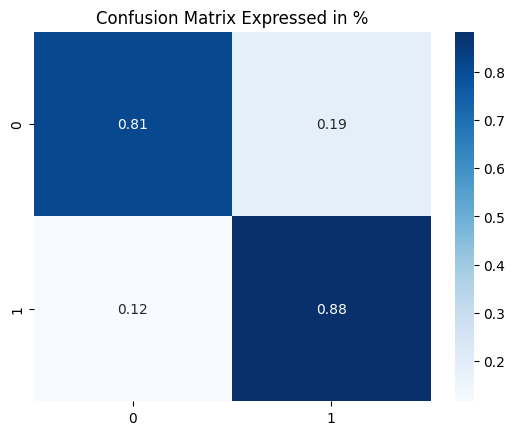

In [26]:
printModelStats(best_model_1, X_test, y_test)

## GRU with Word2Vec Embedding

In [27]:
output_dimension = 100


#Training Word2Vec embedding layer using Skip grams
sentences = [sentence.split() for sentence in X_train_untk]
w2v = Word2Vec(sentences, vector_size = output_dimension, sg=1)

#Creating the embedding weight matrix
embedding_matrix = np.zeros((vocab_size, output_dimension))

for word, i in tokenizer.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]



In [28]:


output_dimension = 100
def buildModel2(hp):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length, weights=[embedding_matrix]))
    model.add((GRU(hp.Choice('units1', [32,64,128]))))
    model.add(Dropout(hp.Choice('rate1', [0.3,0.5, 0.7])))
    model.add(Dense(hp.Choice('units2', [8, 16, 32]), activation = "relu"))
    model.add(Dropout(hp.Choice('rate2', [0.3,0.5, 0.7])))
    model.add(Dense(1, activation = "sigmoid"))
    model.summary()
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [29]:
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [30]:
tuner = kt.RandomSearch(buildModel2, objective= 'val_loss', seed = 8, max_trials=10, directory= 'C:/projects', project_name = 'model_GRU_original_2')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Reloading Tuner from C:/projects\model_GRU_original_2\tuner0.json


In [31]:
best_hp2 = tuner.get_best_hyperparameters()[0]
best_model_2 = tuner.hypermodel.build(best_hp2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           2592800   
                                                                 
 gru_2 (GRU)                 (None, 64)                31872     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2626785 (10.02 MB)
Trainable params: 262

In [32]:
history2 = best_model_2.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)

Epoch 1/20
627/627 [==============================] - 22s 30ms/step - loss: 0.4530 - accuracy: 0.7772 - val_loss: 0.3047 - val_accuracy: 0.8700
Epoch 2/20
627/627 [==============================] - 18s 29ms/step - loss: 0.1905 - accuracy: 0.9313 - val_loss: 0.4079 - val_accuracy: 0.8539
Epoch 3/20
627/627 [==============================] - 18s 29ms/step - loss: 0.0668 - accuracy: 0.9784 - val_loss: 0.5302 - val_accuracy: 0.8449
Epoch 3: early stopping


C:\Users\Bodine Stubbé\AppData\Local\Temp\ipykernel_20136\2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


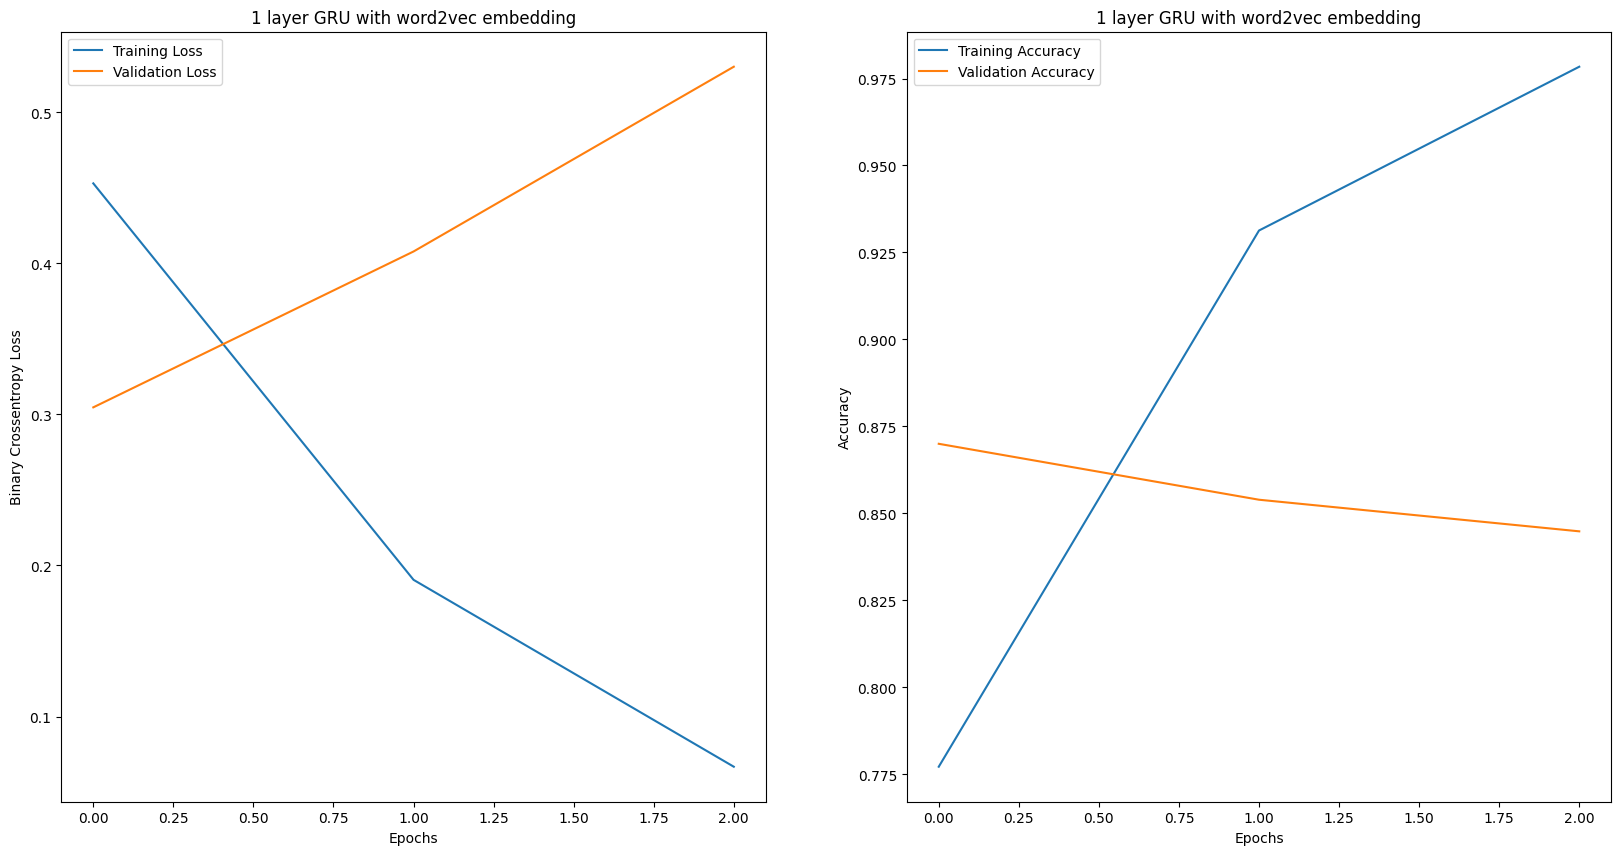

In [33]:
plotCurves(history2, "1 layer GRU with word2vec embedding")

179/179 [==============================] - 1s 4ms/step
               precision    recall  f1-score   support

    Sarcastic       0.89      0.83      0.86      2979
Not Sarcastic       0.83      0.89      0.86      2745

     accuracy                           0.86      5724
    macro avg       0.86      0.86      0.86      5724
 weighted avg       0.86      0.86      0.86      5724

The confusion matrix:
[[2470  509]
 [ 293 2452]]


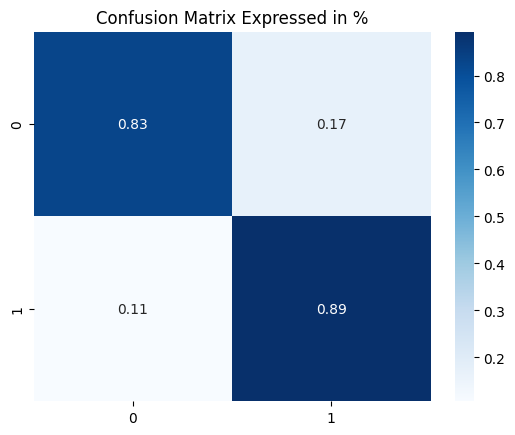

In [34]:
printModelStats(best_model_2, X_test, y_test)


## With glove embedding

In [35]:

from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api

glove_model = api.load("glove-wiki-gigaword-100")

embedding_matrix = np.zeros((vocab_size, output_dimension))

for word, i in tokenizer.word_index.items():
     
    #trying to find word in glove model
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]



In [36]:
output_dimension = 100
def buildModel3(hp):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length, weights=[embedding_matrix]))
    model.add((GRU(hp.Choice('units1', [32,64,128]))))
    model.add(Dropout(hp.Choice('rate1', [0.3,0.5, 0.7])))
    model.add(Dense(hp.Choice('units2', [8, 16, 32]), activation = "relu"))
    model.add(Dropout(hp.Choice('rate2', [0.3,0.5, 0.7])))
    model.add(Dense(1, activation = "sigmoid"))
    model.summary()
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [37]:
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [38]:
tuner = kt.RandomSearch(buildModel3, objective= 'val_loss', seed = 8, max_trials=10, directory= 'C:/projects', project_name = 'model_GRU_original_3')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Reloading Tuner from C:/projects\model_GRU_original_3\tuner0.json


In [39]:
best_hp3 = tuner.get_best_hyperparameters()[0]
best_model_3 = tuner.hypermodel.build(best_hp3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 100)           2592800   
                                                                 
 gru_3 (GRU)                 (None, 64)                31872     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2625201 (10.01 MB)
Trainable params: 262

In [40]:
history = best_model_3.fit(X_train, y_train, epochs = 20, batch_size = 64, validation_data=(X_val, y_val),callbacks = early_stopping)

Epoch 1/20
314/314 [==============================] - 15s 36ms/step - loss: 0.6616 - accuracy: 0.5873 - val_loss: 0.4618 - val_accuracy: 0.7942
Epoch 2/20
314/314 [==============================] - 11s 35ms/step - loss: 0.4500 - accuracy: 0.7705 - val_loss: 0.3269 - val_accuracy: 0.8627
Epoch 3/20
314/314 [==============================] - 11s 34ms/step - loss: 0.3539 - accuracy: 0.8206 - val_loss: 0.3010 - val_accuracy: 0.8725
Epoch 4/20
314/314 [==============================] - 11s 35ms/step - loss: 0.2978 - accuracy: 0.8409 - val_loss: 0.3284 - val_accuracy: 0.8679
Epoch 5/20
314/314 [==============================] - 11s 35ms/step - loss: 0.2451 - accuracy: 0.8611 - val_loss: 0.4432 - val_accuracy: 0.8571
Epoch 5: early stopping


C:\Users\Bodine Stubbé\AppData\Local\Temp\ipykernel_20136\2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


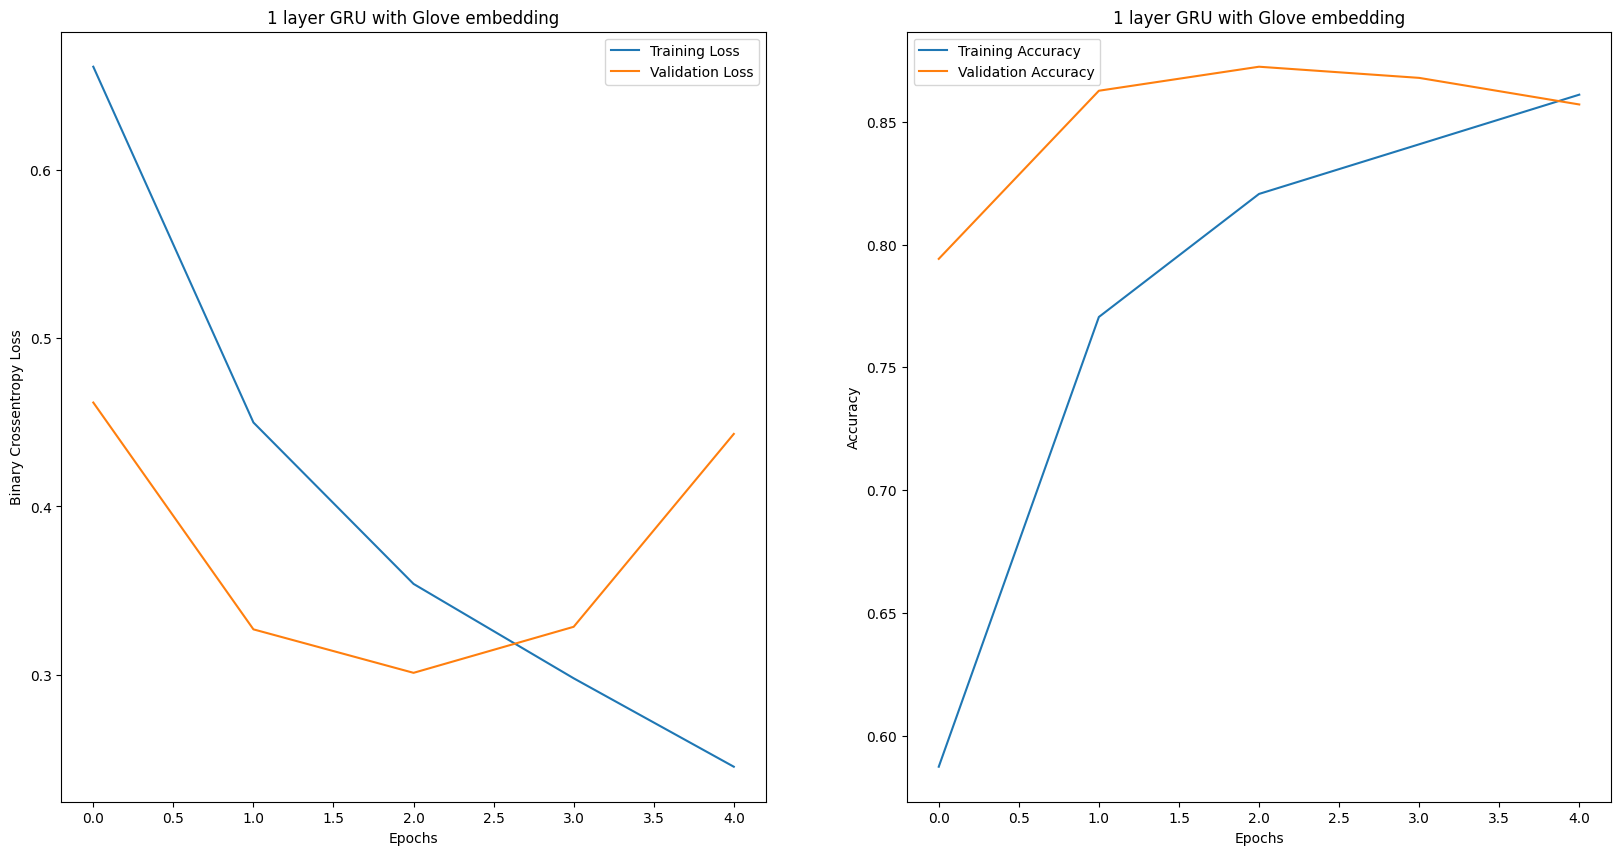

In [41]:
plotCurves(history, "1 layer GRU with Glove embedding")

179/179 [==============================] - 1s 4ms/step
               precision    recall  f1-score   support

    Sarcastic       0.89      0.83      0.86      2979
Not Sarcastic       0.83      0.88      0.86      2745

     accuracy                           0.86      5724
    macro avg       0.86      0.86      0.86      5724
 weighted avg       0.86      0.86      0.86      5724

The confusion matrix:
[[2487  492]
 [ 323 2422]]


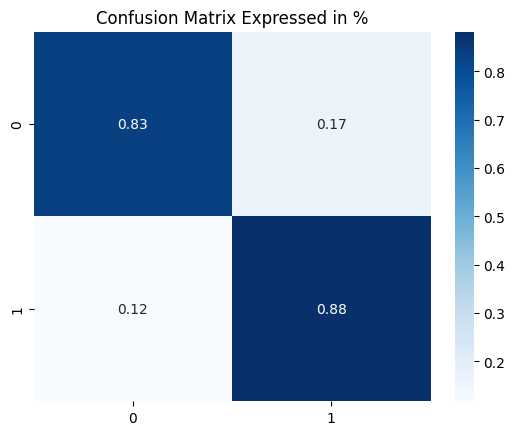

In [42]:
printModelStats(best_model_3, X_test, y_test)